In [69]:
%matplotlib inline
import pyro
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
from pyro.optim import Adam
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

In [3]:
pyro.set_rng_seed(1)
pyro.enable_validation(True)

Read data

In [14]:
fname = "out.csv"
word = "WROCŁAW"

file  = open(fname, 'r', encoding="utf-8")
lines = len(file.readlines())
file  = open(fname, 'r', encoding="utf-8").read()
count = file.count(word)

is_wroclaw = count
is_not_wroclaw = lines - is_wroclaw

print(is_wroclaw)
print(is_not_wroclaw)

2683
4740


In [54]:
def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = torch.tensor(10.0)
    beta0 = torch.tensor(20.0)
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli
        # likelihood Bernoulli(f)
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])

In [55]:
def guide(data):
    # register the two variational parameters with Pyro.
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))

In [56]:
data = []
for _ in range(int(is_wroclaw/100)):
    data.append(torch.tensor(1.0))
for _ in range(int(is_not_wroclaw/100)):
    data.append(torch.tensor(0.0))

In [57]:
# set up the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

pyro.clear_param_store()
losses, means  = [], []
num_steps = 2000
for t in tqdm(range(num_steps)):
    losses.append(svi.step(data))
    alpha = pyro.param("alpha_q")
    beta = pyro.param("beta_q")
    means.append(alpha/(alpha + beta))

In [58]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print(alpha_q, beta_q, inferred_mean, factor, inferred_std)

11.423128128051758 20.91396141052246 0.353251584822603 0.054919120387256916 0.08278390436161036


Text(0, 0.5, 'loss')

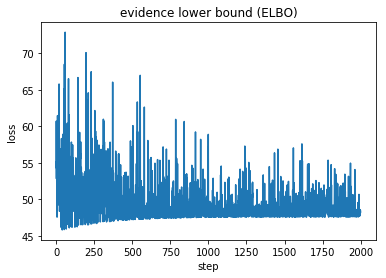

In [59]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss")

Text(0, 0.5, 'mean')

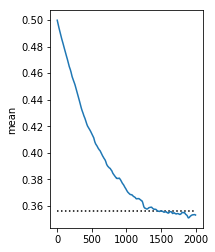

In [60]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[np.mean(data),np.mean(data)], 'k:')
plt.plot(means)
plt.ylabel('mean')

(array([  8.,  23.,  46.,  96., 153., 282., 399., 503., 643., 766., 805.,
        884., 970., 846., 787., 644., 610., 472., 341., 240., 190., 109.,
         76.,  52.,  23.,  16.,   9.,   4.,   1.,   2.]),
 array([0.11413691, 0.13316435, 0.15219179, 0.17121921, 0.19024666,
        0.20927408, 0.22830153, 0.24732895, 0.26635638, 0.28538382,
        0.30441126, 0.3234387 , 0.34246612, 0.36149356, 0.380521  ,
        0.39954844, 0.41857585, 0.4376033 , 0.45663074, 0.47565818,
        0.4946856 , 0.51371306, 0.5327405 , 0.5517679 , 0.57079536,
        0.58982277, 0.6088502 , 0.62787765, 0.64690506, 0.66593254,
        0.68495995], dtype=float32),
 <a list of 30 Patch objects>)

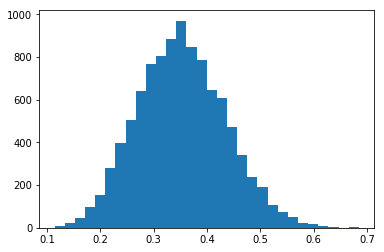

In [75]:
with pyro.plate("name", 10000):
    d = pyro.sample("sample", dist.Beta(alpha_q, beta_q))
    
d = d.numpy()
plt.hist(d, bins=30)